In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
sns.set_style('darkgrid')

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
print(train_df.info())
print('\n\n')
print(train_df.isna().sum().sort_values().tail(19))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<AxesSubplot:>

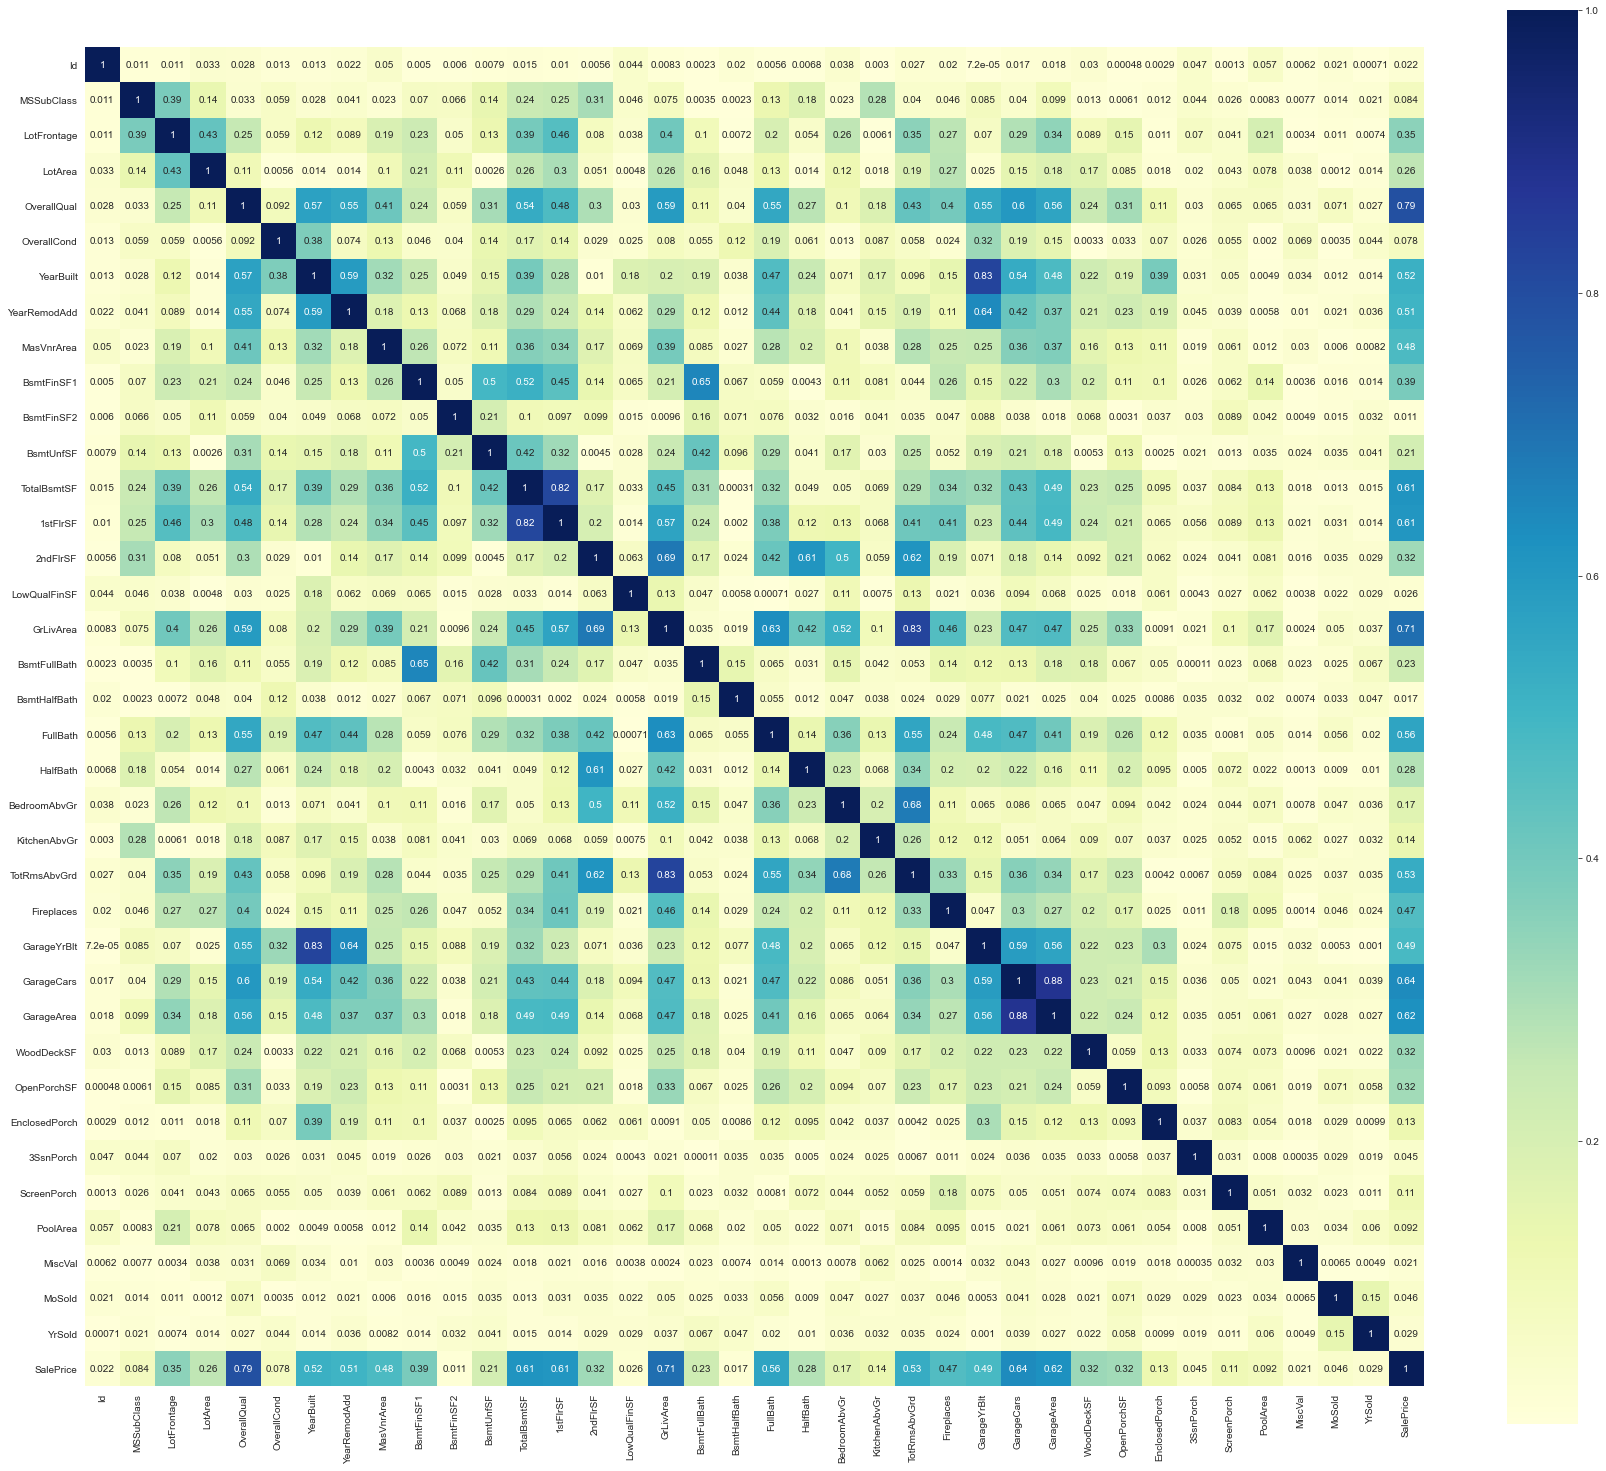

In [3]:
plt.figure(figsize=(30,26))
sns.heatmap(train_df.select_dtypes(include=np.number).corr().abs(), annot=True, square=True, cmap="YlGnBu")

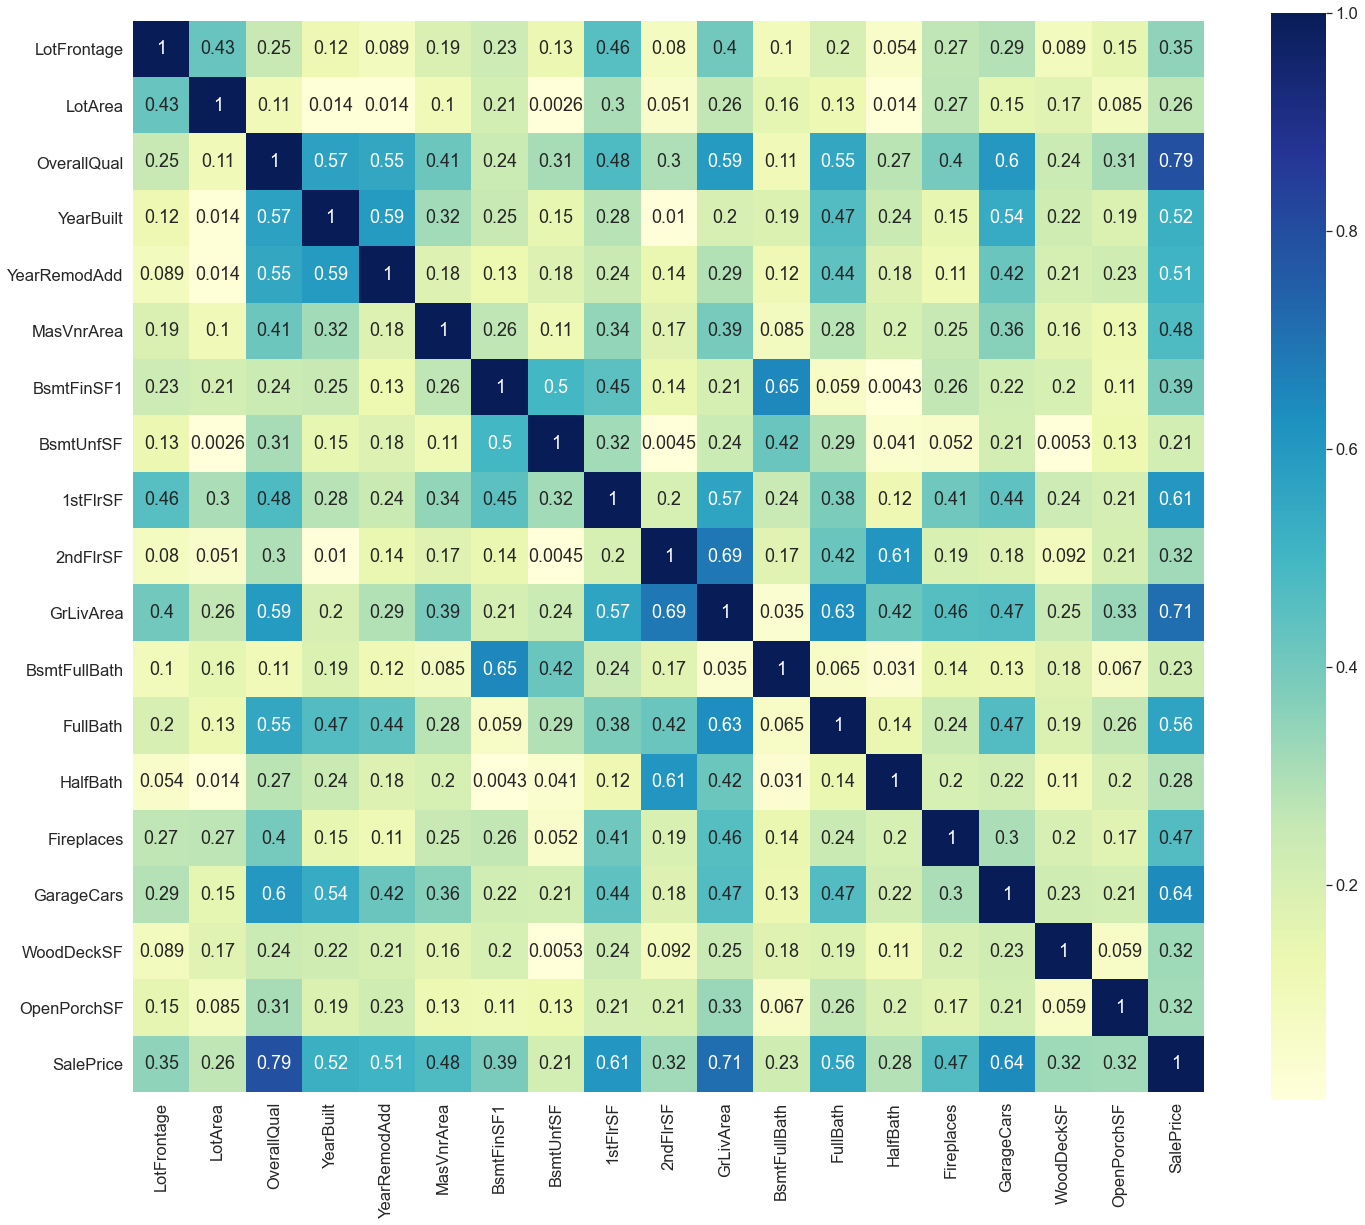

In [4]:
correlations = train_df.select_dtypes(include=np.number).corr().abs()['SalePrice']
high_correlations = correlations.loc[correlations > .2].index

# drop columns that are correlated to each other
high_correlations = high_correlations.drop(['GarageYrBlt', 'GarageArea', 'TotRmsAbvGrd', 'TotalBsmtSF'])

plt.figure(figsize=(24, 20))
sns.set(font_scale=1.5)
sns.heatmap(train_df[high_correlations].corr().abs(), annot=True, square=True, cmap="YlGnBu")
sns.set(font_scale=1)

In [5]:
na_sums = train_df.isna().sum()
print(na_sums.loc[na_sums > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [6]:
def factorize_categories(df, columns):
    data = df.copy()
    for col in columns:
        data[col] = pd.factorize(data[col])[0] + 1
    
    return data

In [7]:
# category_features = ['MSZoning', 'Street', 'Alley', 'LotShape']
category_features = list(train_df.select_dtypes(include=['object']).columns)
print(category_features)
factorized_df = factorize_categories(train_df, category_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


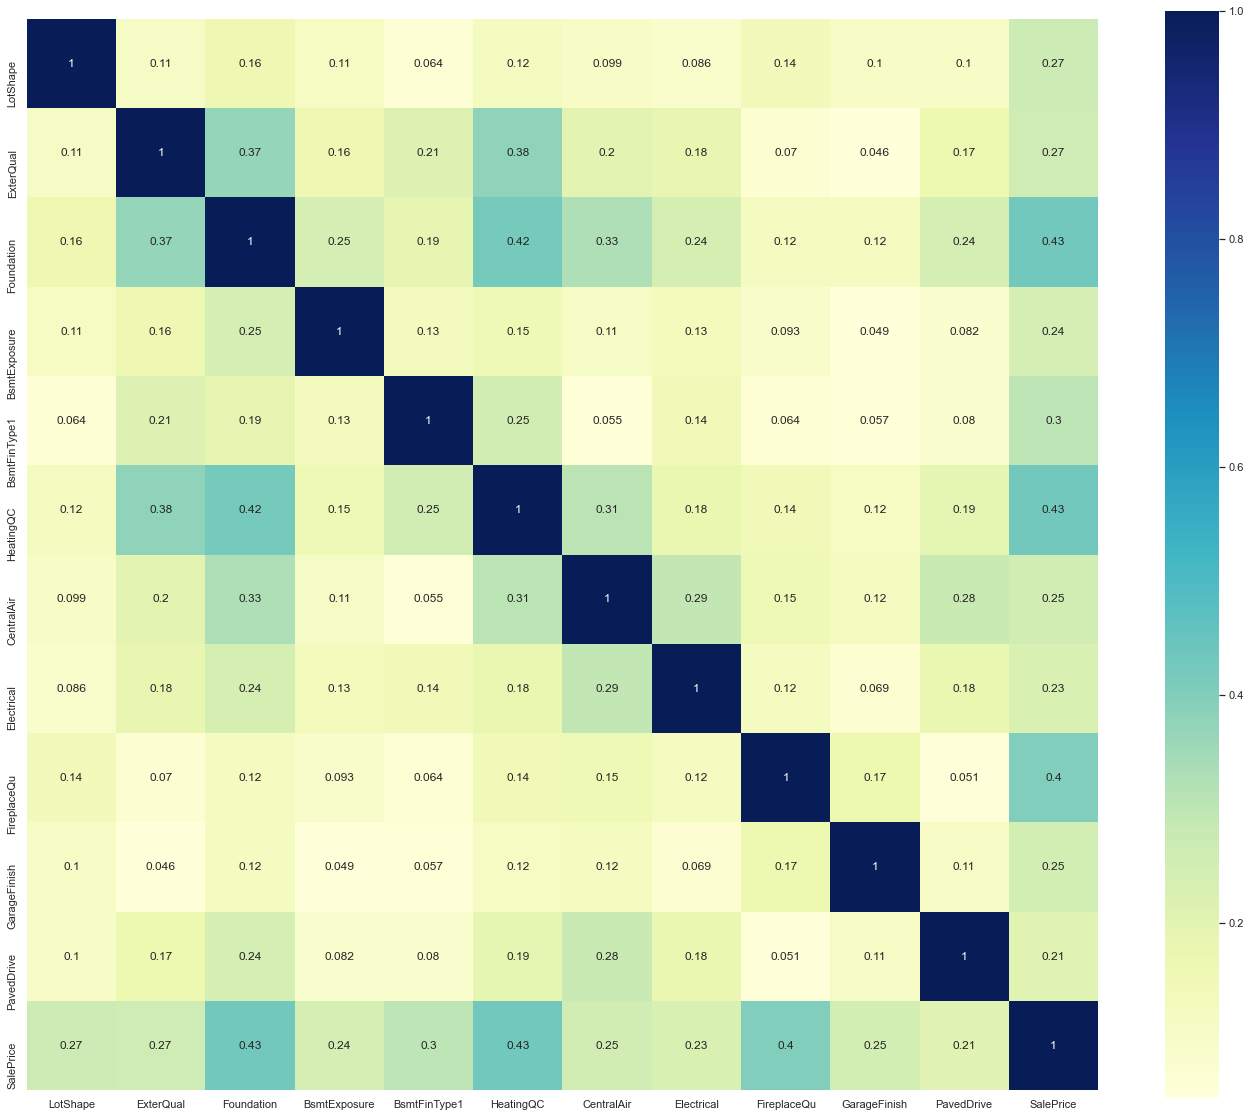

In [8]:
category_correlations = factorized_df[category_features + ['SalePrice']].corr().abs()['SalePrice']
high_cat_correlations = category_correlations.loc[category_correlations > .2].index

plt.figure(figsize=(24, 20))
sns.heatmap(factorized_df[high_cat_correlations].corr().abs(), annot=True, square=True, cmap="YlGnBu")

features = high_correlations.append(high_cat_correlations.drop('SalePrice'))

In [30]:
features_df = factorized_df[features]
print(features_df.info())

X = features_df.drop(columns='SalePrice')
y = features_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   OverallQual   1460 non-null   int64  
 3   YearBuilt     1460 non-null   int64  
 4   YearRemodAdd  1460 non-null   int64  
 5   MasVnrArea    1452 non-null   float64
 6   BsmtFinSF1    1460 non-null   int64  
 7   BsmtUnfSF     1460 non-null   int64  
 8   1stFlrSF      1460 non-null   int64  
 9   2ndFlrSF      1460 non-null   int64  
 10  GrLivArea     1460 non-null   int64  
 11  BsmtFullBath  1460 non-null   int64  
 12  FullBath      1460 non-null   int64  
 13  HalfBath      1460 non-null   int64  
 14  Fireplaces    1460 non-null   int64  
 15  GarageCars    1460 non-null   int64  
 16  WoodDeckSF    1460 non-null   int64  
 17  OpenPorchSF   1460 non-null   int64  
 18  SalePrice     1460 non-null 

In [39]:
model = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=150,
    min_child_weight=.3, 
    colsample_bytree=.5, 
    subsample=0.5, 
    sampling_method='gradient_based',
    eta=0.1,
    tree_method='gpu_hist',
    max_bin = 2048,
    seed=42,
    use_label_encoder=False,
    n_jobs=-1)

eval_metric = 'rmsle'

# parameters = {
# 'eta': np.arange(.05, .25, .05)
# }


# grid = GridSearchCV(model, parameters, n_jobs=-1, scoring='neg_mean_squared_log_error', verbose=2)
# grid.fit(X, y)

# print(grid.best_params_)

model.fit(
    X_train, 
    y_train, 
    eval_metric=eval_metric, 
    eval_set=[(X_train, y_train),(X_val, y_val)], 
    verbose=True,
    early_stopping_rounds=30
    )

[0]	validation_0-rmsle:2.29935	validation_1-rmsle:2.29544
[1]	validation_0-rmsle:1.65985	validation_1-rmsle:1.65296
[2]	validation_0-rmsle:1.30491	validation_1-rmsle:1.30006
[3]	validation_0-rmsle:1.06483	validation_1-rmsle:1.05737
[4]	validation_0-rmsle:0.88731	validation_1-rmsle:0.88091
[5]	validation_0-rmsle:0.75343	validation_1-rmsle:0.74756
[6]	validation_0-rmsle:0.64628	validation_1-rmsle:0.64242
[7]	validation_0-rmsle:0.55964	validation_1-rmsle:0.55971
[8]	validation_0-rmsle:0.48927	validation_1-rmsle:0.49085
[9]	validation_0-rmsle:0.42981	validation_1-rmsle:0.43394
[10]	validation_0-rmsle:0.37889	validation_1-rmsle:0.38610
[11]	validation_0-rmsle:0.33565	validation_1-rmsle:0.34534
[12]	validation_0-rmsle:0.29914	validation_1-rmsle:0.31151
[13]	validation_0-rmsle:0.26927	validation_1-rmsle:0.28445
[14]	validation_0-rmsle:0.24227	validation_1-rmsle:0.26079
[15]	validation_0-rmsle:0.22029	validation_1-rmsle:0.24246
[16]	validation_0-rmsle:0.20202	validation_1-rmsle:0.22631
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.1, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_bin=2048, max_delta_step=0,
             max_depth=5, min_child_weight=0.3, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, seed=42,
             subsample=0.5, tree_method='gpu_hist', use_label_encoder=False,
             validate_parameters=1, ...)

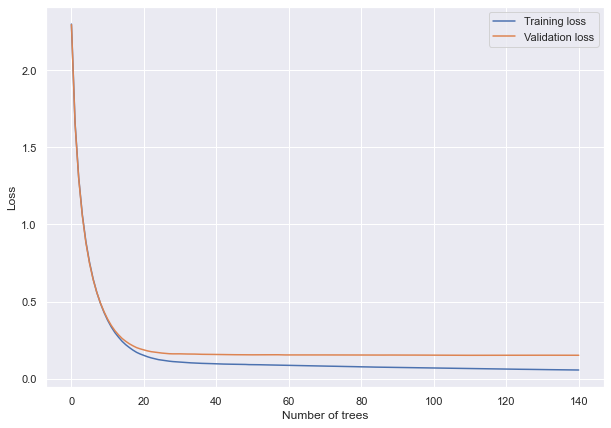

In [40]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][eval_metric], label="Training loss")
plt.plot(results["validation_1"][eval_metric], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

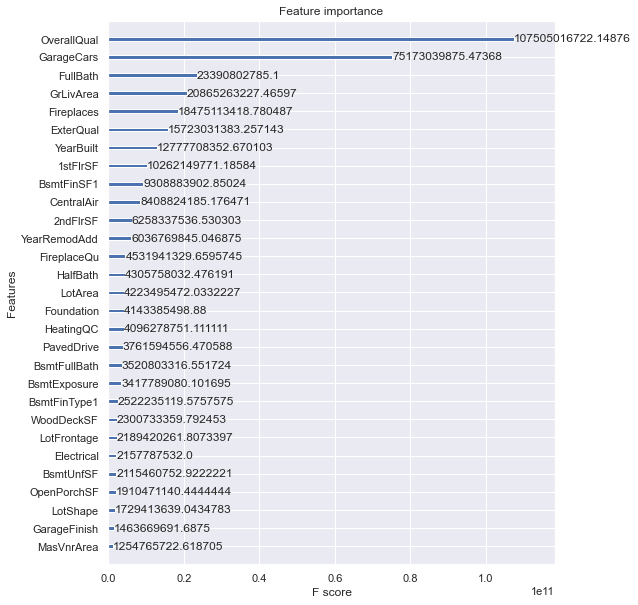

In [41]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, importance_type='gain')

plot_features(model, (8,10))

In [42]:
category_features = list(test_df.select_dtypes(include=['object']).columns)
factorized_test_df = factorize_categories(test_df, category_features)

test_X = factorized_test_df[features.drop('SalePrice')]

predictions = model.predict(test_X)
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})

print(submission.info())
print('\n')
print(submission.nunique())
submission.to_csv('submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB
None


Id           1459
SalePrice    1455
dtype: int64
